## With EDA 1 It gaves us a hint that with PCA the activities are spatially sepearted with static activities towards the left and dynamic activities towards the right. Based on this knowledge we have used a different set of labels[sleep, light, sedentary, moderate-vigorous] to hide away the heirarchy.

In [1]:
cd /Users/akashmurali/Documents/capstone/project

/Users/akashmurali/Documents/capstone/project


In [2]:
import pandas as pd
import os

# load as a df
df_147 = pd.read_csv("capture24/P147.csv", index_col="time", parse_dates=["time"], dtype={'x': 'f4', 'y': 'f4', 'z': 'f4', 'annotation': 'string'})

In [3]:
# load annotation-label-dictionary.csv as df to remap the annotation to proper labels
annotation_df = pd.read_csv("capture24/annotation-label-dictionary.csv", index_col = "annotation", dtype = "string")
annotation_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206 entries, 7030 sleeping;MET 0.95 to vehicle;MET 1.3
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   label:WillettsSpecific2018  206 non-null    string
 1   label:WillettsMET2018       206 non-null    string
 2   label:DohertySpecific2018   206 non-null    string
 3   label:Willetts2018          206 non-null    string
 4   label:Doherty2018           206 non-null    string
 5   label:Walmsley2020          206 non-null    string
dtypes: string(6)
memory usage: 11.3+ KB


In [16]:
annotation_df.head()

,label:WillettsSpecific2018,label:WillettsMET2018,label:DohertySpecific2018,label:Willetts2018,label:Doherty2018,label:Walmsley2020
annotation,,,,,,
7030 sleeping;MET 0.95,sleep,sleep,sleep,sleep,sleep,sleep
occupation;office and administrative support;11580 office/computer work general;MET 1.5,sitting,sitstand+lowactivity,sedentary-screen,sit-stand,sedentary,sedentary
home activity;household chores;preparing meals/cooking/washing dishes;5035 kitchen activity general cooking/washing/dishes/cleaning up;MET 3.3,household-chores,sitstand+activity,tasks-moderate,mixed,moderate,light
occupation;office and administrative support;11580 office wok/computer work general;MET 1.5,sitting,sitstand+lowactivity,sedentary-screen,sit-stand,sedentary,sedentary
home activity;miscellaneous;sitting;9060 sitting/lying reading or without observable/identifiable activities;MET 1.3,sitting,sitstand+lowactivity,sedentary-non-screen,sit-stand,sedentary,sedentary


In [4]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [5]:
# Direct mapping
df_147['activity_label'] = df_147['annotation'].map(annotation_df['label:Walmsley2020'])

# Check for unmapped
print(f"Unmapped rows: {df_147['activity_label'].isna().sum()}")

Unmapped rows: 2788381


In [6]:
df_147['activity_label'].nunique()

4

In [7]:
from tqdm import tqdm
import numpy as np

def extract_windows(data, winsize='10s'):
    X, Y = [], []
    for t, w in tqdm(data.resample(winsize, origin='start')):

        # Check window has no NaNs and is of correct length
        if w.isna().any().any() or len(w) != 1000:
            continue

        x = w[['x', 'y', 'z']].to_numpy()
        y = w['activity_label'].mode(dropna=False).item()

        X.append(x)
        Y.append(y)

    X = np.stack(X)
    Y = np.stack(Y)

    return X, Y

In [8]:
X, Y =extract_windows(df_147)

100%|██████████| 9721/9721 [00:02<00:00, 4426.83it/s]


In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def apply_pca_visualization(X, Y, n_components=2):
    """
    Apply PCA to visualize activity clusters in 2D
    
    Parameters:
    -----------
    X : np.array
        Shape (n_windows, 1000, 3) - windowed acceleration data
    Y : np.array
        Shape (n_windows,) - activity labels
    
    Returns:
    --------
    plotly figure
    """
    # Flatten each window into a feature vector
    # From (n_windows, 1000, 3) to (n_windows, 3000)
    X_flattened = X.reshape(X.shape[0], -1)
    
    print(f"Original shape: {X.shape}")
    print(f"Flattened shape: {X_flattened.shape}")
    
    # Standardize features (PCA needs normalization)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flattened)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Create dataframe for plotting
    df_pca = pd.DataFrame({
        'PC1': X_pca[:, 0],
        'PC2': X_pca[:, 1],
        'Activity': Y
    })
    
    # Print explained variance
    explained_var = pca.explained_variance_ratio_
    print(f"\nExplained variance ratio:")
    for i, var in enumerate(explained_var):
        print(f"  PC{i+1}: {var*100:.2f}%")
    print(f"  Total: {sum(explained_var)*100:.2f}%")
    
    # Create visualization
    fig = px.scatter(
        df_pca,
        x='PC1',
        y='PC2',
        color='Activity',
        title=f'PCA: Activity Clustering <br>Explained Variance: PC1={explained_var[0]*100:.1f}%, PC2={explained_var[1]*100:.1f}%',
        labels={'PC1': f'PC1 ({explained_var[0]*100:.1f}%)', 
                'PC2': f'PC2 ({explained_var[1]*100:.1f}%)'},
        opacity=0.6,
        height=600
    )
    
    fig.update_traces(marker=dict(size=5))
    
    return fig, pca, df_pca

# Apply 2D PCA
fig_2d, pca_model, df_pca = apply_pca_visualization(X, Y, n_components=2)
fig_2d.show()

Original shape: (6826, 1000, 3)
Flattened shape: (6826, 3000)

Explained variance ratio:
  PC1: 31.17%
  PC2: 28.30%
  Total: 59.47%


#### the seperation is much more evident with by hiding way the heirarchy.|

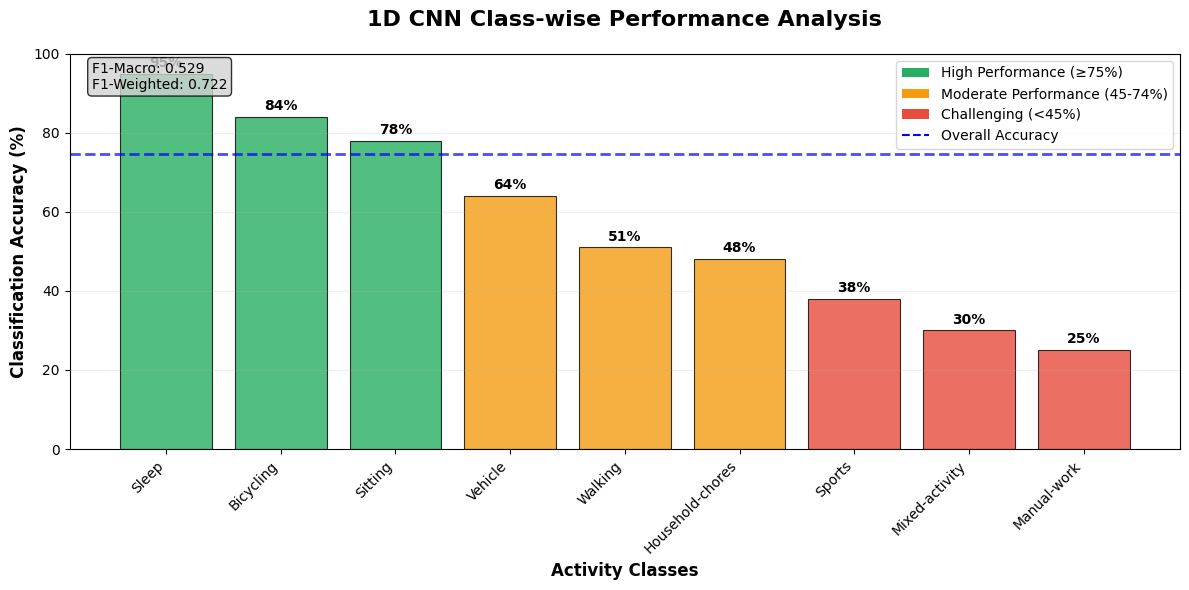

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your results
activities = ['Sleep', 'Bicycling', 'Sitting', 'Vehicle', 'Walking', 
              'Household-chores', 'Sports', 'Mixed-activity', 'Manual-work']
accuracies = [95, 84, 78, 64, 51, 48, 38, 30, 25]  # Manual-work estimated

# Color coding based on performance tiers
colors = []
for acc in accuracies:
    if acc >= 75:
        colors.append('#27ae60')  # High performing - Green
    elif acc >= 45:
        colors.append('#f39c12')  # Moderate performing - Orange  
    else:
        colors.append('#e74c3c')  # Challenging - Red

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(activities, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=0.8)

# Add value labels on top of bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Customize the plot
plt.title('1D CNN Class-wise Performance Analysis', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Activity Classes', fontsize=12, fontweight='bold')
plt.ylabel('Classification Accuracy (%)', fontsize=12, fontweight='bold')
plt.ylim(0, 100)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add horizontal line at overall accuracy
plt.axhline(y=74.55, color='blue', linestyle='--', alpha=0.7, linewidth=2, 
            label='Overall Validation Accuracy (74.55%)')

# Add legend for performance tiers
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#27ae60', label='High Performance (≥75%)'),
    Patch(facecolor='#f39c12', label='Moderate Performance (45-74%)'),
    Patch(facecolor='#e74c3c', label='Challenging (<45%)'),
    plt.Line2D([0], [0], color='blue', linestyle='--', label='Overall Accuracy')
]
plt.legend(handles=legend_elements, loc='upper right')

# Add F1 scores as text box
textstr = f'F1-Macro: 0.529\nF1-Weighted: 0.722'
props = dict(boxstyle='round', facecolor='lightgray', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

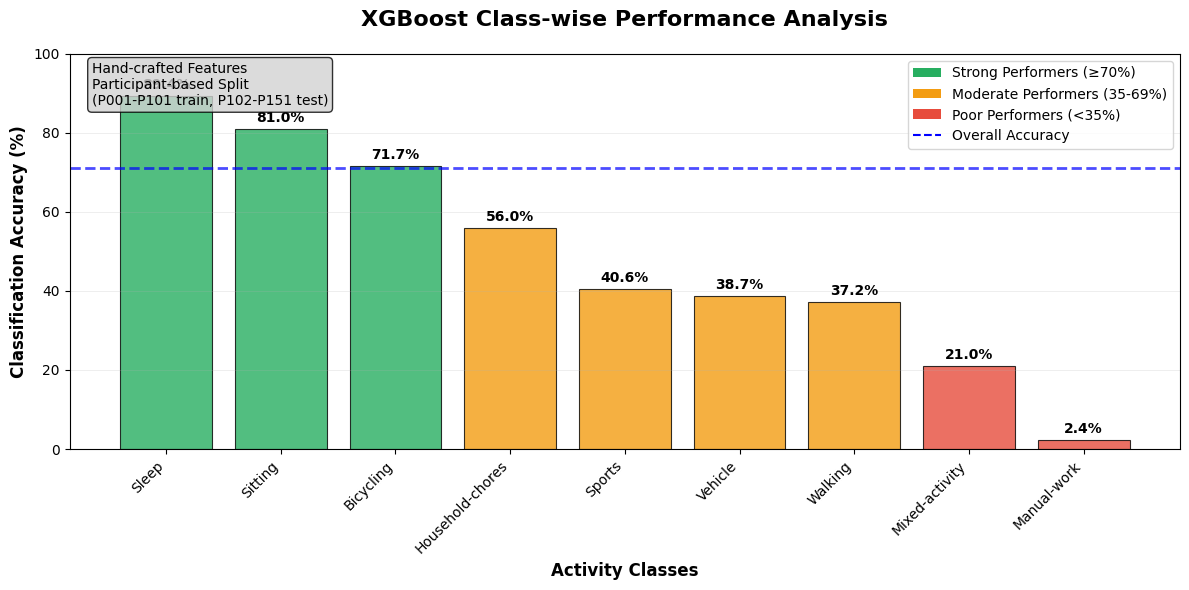

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your XGBoost results
activities = ['Sleep', 'Sitting', 'Bicycling', 'Household-chores', 'Sports', 
              'Vehicle', 'Walking', 'Mixed-activity', 'Manual-work']
accuracies = [89.4, 81.0, 71.7, 56.0, 40.6, 38.7, 37.2, 21.0, 2.4]

# Color coding based on performance tiers
colors = []
for acc in accuracies:
    if acc >= 70:
        colors.append('#27ae60')  # Strong performers - Green
    elif acc >= 35:
        colors.append('#f39c12')  # Moderate performers - Orange  
    else:
        colors.append('#e74c3c')  # Poor performers - Red

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(activities, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=0.8)

# Add value labels on top of bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Customize the plot
plt.title('XGBoost Class-wise Performance Analysis', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Activity Classes', fontsize=12, fontweight='bold')
plt.ylabel('Classification Accuracy (%)', fontsize=12, fontweight='bold')
plt.ylim(0, 100)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add horizontal line at overall accuracy (71% from your paper)
plt.axhline(y=71, color='blue', linestyle='--', alpha=0.7, linewidth=2, 
            label='Overall Test Accuracy (71%)')

# Add legend for performance tiers
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#27ae60', label='Strong Performers (≥70%)'),
    Patch(facecolor='#f39c12', label='Moderate Performers (35-69%)'),
    Patch(facecolor='#e74c3c', label='Poor Performers (<35%)'),
    plt.Line2D([0], [0], color='blue', linestyle='--', label='Overall Accuracy')
]
plt.legend(handles=legend_elements, loc='upper right')

# Add note about feature-based approach
textstr = 'Hand-crafted Features\nParticipant-based Split\n(P001-P101 train, P102-P151 test)'
props = dict(boxstyle='round', facecolor='lightgray', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

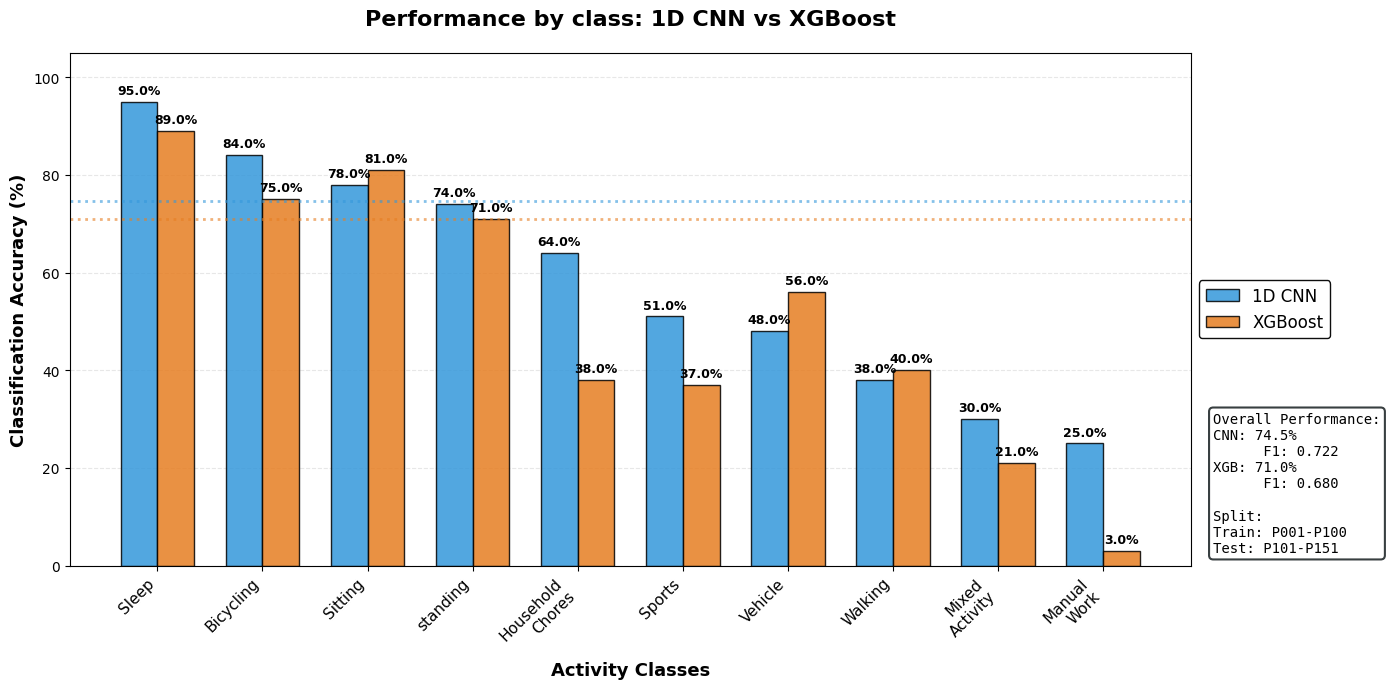

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Data
activities = ['Sleep', 'Sitting', 'Bicycling', 'standing', 'Household\nChores', 'Sports', 
              'Vehicle', 'Walking', 'Mixed\nActivity', 'Manual\nWork']

cnn_accuracies = [95, 78, 84, 74, 64, 51, 48, 38, 30, 25]
xgb_accuracies = [89, 81, 75, 71, 38, 37, 56, 40, 21, 3]

# Sort by CNN performance for better visualization
sorted_indices = np.argsort(cnn_accuracies)[::-1]
activities = [activities[i] for i in sorted_indices]
cnn_accuracies = [cnn_accuracies[i] for i in sorted_indices]
xgb_accuracies = [xgb_accuracies[i] for i in sorted_indices]

# Create figure
fig, ax = plt.subplots(figsize=(14, 7))

# Bar positions
x = np.arange(len(activities))
width = 0.35

# Create bars
bars1 = ax.bar(x - width/2, cnn_accuracies, width, 
               label='1D CNN', color='#3498db', alpha=0.85, edgecolor='black', linewidth=1)
bars2 = ax.bar(x + width/2, xgb_accuracies, width,
               label='XGBoost', color='#e67e22', alpha=0.85, edgecolor='black', linewidth=1)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Customize plot
ax.set_xlabel('Activity Classes', fontsize=13, fontweight='bold')
ax.set_ylabel('Classification Accuracy (%)', fontsize=13, fontweight='bold')
ax.set_title('Performance by class: 1D CNN vs XGBoost', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(activities, rotation=45, ha='right', fontsize=11)
ax.set_ylim(0, 105)

# Add grid
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Legend
ax.legend(loc='upper right', fontsize=12, framealpha=0.95, edgecolor='black')

# Add overall accuracy lines
cnn_overall = 74.55
xgb_overall = 71.0

ax.axhline(y=cnn_overall, color='#3498db', linestyle=':', alpha=0.6, linewidth=2)
ax.axhline(y=xgb_overall, color='#e67e22', linestyle=':', alpha=0.6, linewidth=2)

# Legend positioned outside plot area
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, 
          framealpha=0.95, edgecolor='black')

# Add text box with summary (moved to avoid overlap)
textstr = '\n'.join([
    'Overall Performance:',
    f'CNN: {cnn_overall:.1f}%',
    f'      F1: 0.722',
    f'XGB: {xgb_overall:.1f}%',
    f'      F1: 0.680',
    '',
    'Split:',
    'Train: P001-P100',
    'Test: P101-P151'
])
props = dict(boxstyle='round', facecolor='white', alpha=0.95, 
             edgecolor='#2d3436', linewidth=1.5)
ax.text(1.02, 0.02, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', bbox=props, family='monospace')

plt.tight_layout()
plt.savefig('model_comparison_professional.png', dpi=300, bbox_inches='tight')
plt.show()

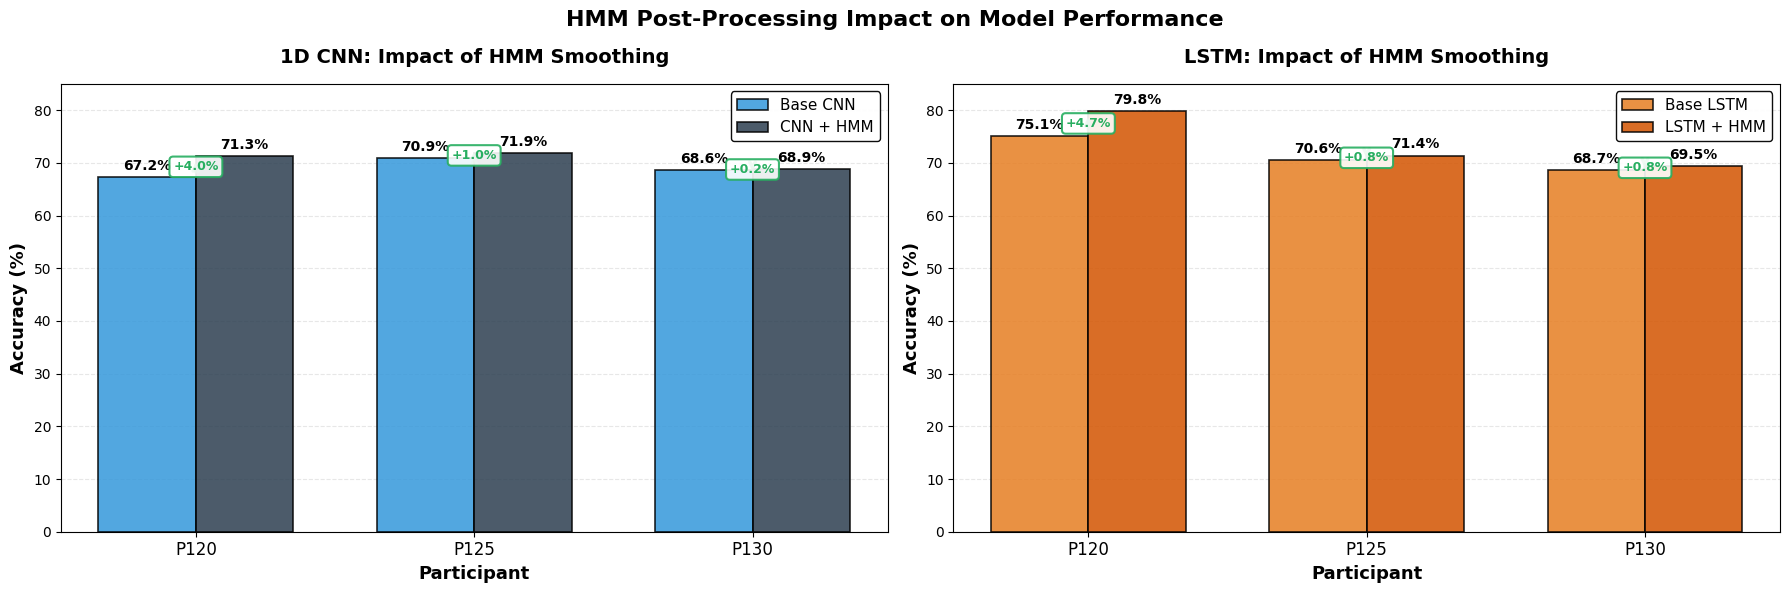


HMM IMPROVEMENT SUMMARY

CNN:
  Average base accuracy: 68.92%
  Average HMM accuracy: 70.68%
  Average improvement: +1.76%

LSTM:
  Average base accuracy: 71.45%
  Average HMM accuracy: 73.55%
  Average improvement: +2.10%


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load results
cnn_results = pd.read_csv('/Users/akashmurali/Documents/capstone/project/HAR/human-activity-recognition/time-series/cnn_hmm_results.csv')
lstm_results = pd.read_csv('/Users/akashmurali/Documents/capstone/project/HAR/human-activity-recognition/time-series/lstm_hmm_results.csv')

# Filter for P120, P125, P130
participants = ['P120', 'P125', 'P130']
cnn_filtered = cnn_results[cnn_results['participant'].isin(participants)]
lstm_filtered = lstm_results[lstm_results['participant'].isin(participants)]

# Create figure with extra space for legends
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# ============================================================================
# LEFT PLOT: CNN
# ============================================================================

ax1 = axes[0]

x = np.arange(len(participants))
width = 0.35

# Bars
bars1 = ax1.bar(x - width/2, cnn_filtered['base_accuracy'].values, width,
               label='Base CNN', color='#3498db', alpha=0.85, edgecolor='black', linewidth=1.2)
bars2 = ax1.bar(x + width/2, cnn_filtered['hmm_accuracy'].values, width,
               label='CNN + HMM', color='#2c3e50', alpha=0.85, edgecolor='black', linewidth=1.2)

# Value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.8,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.8,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Improvement arrows
for i, (base, hmm) in enumerate(zip(cnn_filtered['base_accuracy'].values, 
                                     cnn_filtered['hmm_accuracy'].values)):
    if hmm > base:
        ax1.annotate('', xy=(i, hmm - 0.5), xytext=(i, base + 0.5),
                    arrowprops=dict(arrowstyle='->', color='#27ae60', lw=2.5, alpha=0.7))
        improvement = hmm - base
        ax1.text(i, (base + hmm) / 2, f'+{improvement:.1f}%', 
                ha='center', va='center', fontsize=9, fontweight='bold',
                color='#27ae60', bbox=dict(boxstyle='round', facecolor='white', 
                                          edgecolor='#27ae60', alpha=0.9, linewidth=1.5))

ax1.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Participant', fontsize=13, fontweight='bold')
ax1.set_title('1D CNN: Impact of HMM Smoothing', fontsize=14, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(participants, fontsize=12)
ax1.set_ylim(0, 85)
ax1.legend(loc='upper right', fontsize=11, framealpha=0.95, edgecolor='black')
ax1.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
ax1.set_axisbelow(True)

# ============================================================================
# RIGHT PLOT: LSTM
# ============================================================================

ax2 = axes[1]

# Bars
bars3 = ax2.bar(x - width/2, lstm_filtered['base_accuracy'].values, width,
               label='Base LSTM', color='#e67e22', alpha=0.85, edgecolor='black', linewidth=1.2)
bars4 = ax2.bar(x + width/2, lstm_filtered['hmm_accuracy'].values, width,
               label='LSTM + HMM', color='#d35400', alpha=0.85, edgecolor='black', linewidth=1.2)

# Value labels
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.8,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

for bar in bars4:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.8,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Improvement arrows
for i, (base, hmm) in enumerate(zip(lstm_filtered['base_accuracy'].values, 
                                     lstm_filtered['hmm_accuracy'].values)):
    if hmm > base:
        ax2.annotate('', xy=(i, hmm - 0.5), xytext=(i, base + 0.5),
                    arrowprops=dict(arrowstyle='->', color='#27ae60', lw=2.5, alpha=0.7))
        improvement = hmm - base
        ax2.text(i, (base + hmm) / 2, f'+{improvement:.1f}%', 
                ha='center', va='center', fontsize=9, fontweight='bold',
                color='#27ae60', bbox=dict(boxstyle='round', facecolor='white', 
                                          edgecolor='#27ae60', alpha=0.9, linewidth=1.5))

ax2.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Participant', fontsize=13, fontweight='bold')
ax2.set_title('LSTM: Impact of HMM Smoothing', fontsize=14, fontweight='bold', pad=15)
ax2.set_xticks(x)
ax2.set_xticklabels(participants, fontsize=12)
ax2.set_ylim(0, 85)
ax2.legend(loc='upper right', fontsize=11, framealpha=0.95, edgecolor='black')
ax2.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
ax2.set_axisbelow(True)

plt.suptitle('HMM Post-Processing Impact on Model Performance', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.savefig('hmm_impact_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*70)
print("HMM IMPROVEMENT SUMMARY")
print("="*70)

print("\nCNN:")
print(f"  Average base accuracy: {cnn_filtered['base_accuracy'].mean():.2f}%")
print(f"  Average HMM accuracy: {cnn_filtered['hmm_accuracy'].mean():.2f}%")
print(f"  Average improvement: +{cnn_filtered['improvement'].mean():.2f}%")

print("\nLSTM:")
print(f"  Average base accuracy: {lstm_filtered['base_accuracy'].mean():.2f}%")
print(f"  Average HMM accuracy: {lstm_filtered['hmm_accuracy'].mean():.2f}%")
print(f"  Average improvement: +{lstm_filtered['improvement'].mean():.2f}%")

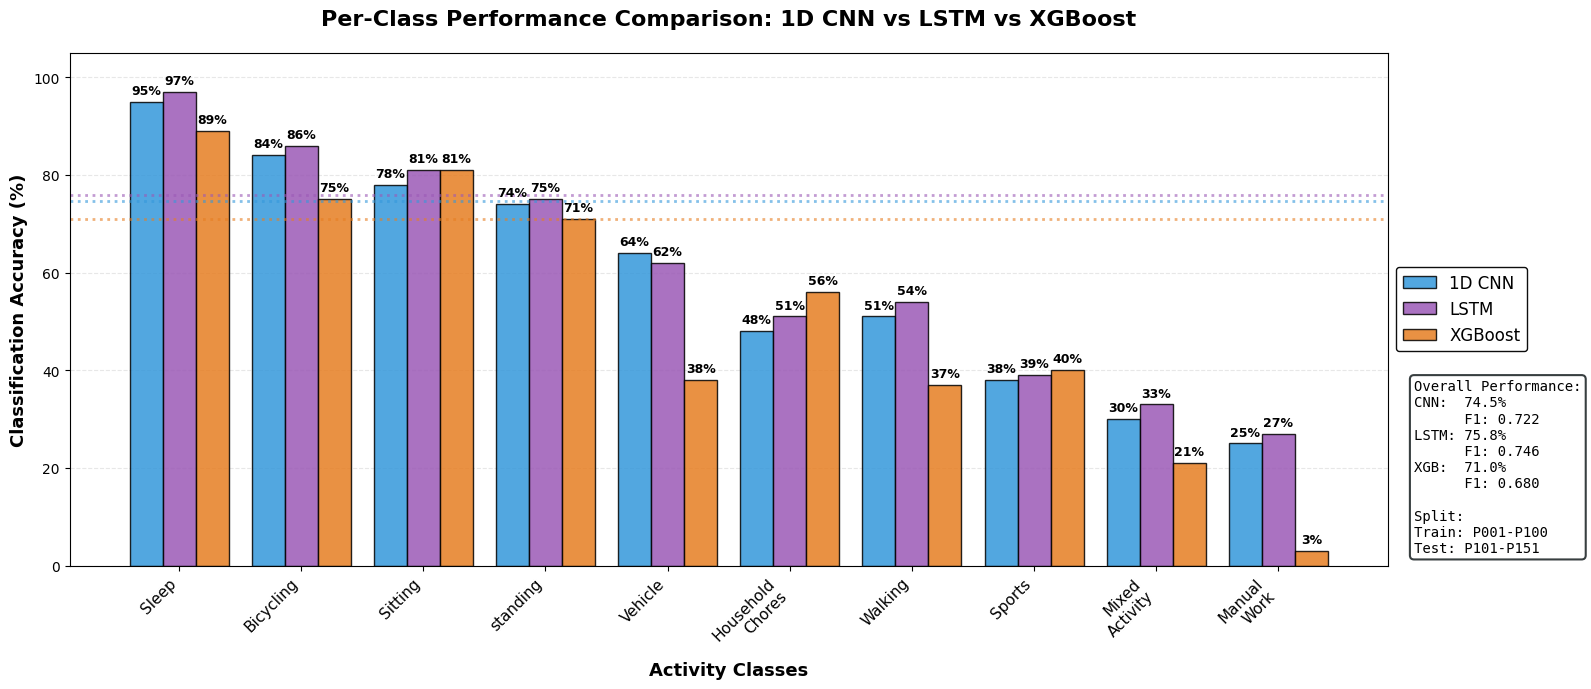


MODEL PERFORMANCE COMPARISON

Activity             CNN      LSTM     XGBoost  Best Model
----------------------------------------------------------------------
Sleep                95       97       89       LSTM
Bicycling            84       86       75       LSTM
Sitting              78       81       81       LSTM
standing             74       75       71       LSTM
Vehicle              64       62       38       CNN
Household Chores     48       51       56       XGB
Walking              51       54       37       LSTM
Sports               38       39       40       XGB
Mixed Activity       30       33       21       LSTM
Manual Work          25       27       3        LSTM

Overall              74.5     75.8     71.0     LSTM


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Data
activities = ['Sleep', 'Sitting', 'Bicycling', 'standing', 'Household\nChores', 'Sports', 
              'Vehicle', 'Walking', 'Mixed\nActivity', 'Manual\nWork']

cnn_accuracies = [95, 78, 84, 74, 48, 38, 64, 51, 30, 25]
xgb_accuracies = [89, 81, 75, 71, 56, 40, 38, 37, 21, 3]
lstm_accuracies = [97, 81, 86, 75, 51, 39, 62, 54, 33, 27]

# Sort by best performance across all models
best_acc = [max(c, x, l) for c, x, l in zip(cnn_accuracies, xgb_accuracies, lstm_accuracies)]
sorted_indices = np.argsort(best_acc)[::-1]

activities = [activities[i] for i in sorted_indices]
cnn_accuracies = [cnn_accuracies[i] for i in sorted_indices]
xgb_accuracies = [xgb_accuracies[i] for i in sorted_indices]
lstm_accuracies = [lstm_accuracies[i] for i in sorted_indices]

# Create figure with extra space for legend
fig, ax = plt.subplots(figsize=(16, 7))

# Bar positions
x = np.arange(len(activities))
width = 0.27

# Create bars
bars1 = ax.bar(x - width, cnn_accuracies, width, 
               label='1D CNN', color='#3498db', alpha=0.85, edgecolor='black', linewidth=1)
bars2 = ax.bar(x, lstm_accuracies, width,
               label='LSTM', color='#9b59b6', alpha=0.85, edgecolor='black', linewidth=1)
bars3 = ax.bar(x + width, xgb_accuracies, width,
               label='XGBoost', color='#e67e22', alpha=0.85, edgecolor='black', linewidth=1)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.0f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Customize plot
ax.set_xlabel('Activity Classes', fontsize=13, fontweight='bold')
ax.set_ylabel('Classification Accuracy (%)', fontsize=13, fontweight='bold')
ax.set_title('Per-Class Performance Comparison: 1D CNN vs LSTM vs XGBoost', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(activities, rotation=45, ha='right', fontsize=11)
ax.set_ylim(0, 105)

# Add grid
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Overall accuracy reference lines
cnn_overall = 74.55
lstm_overall = 75.8
xgb_overall = 71.0

ax.axhline(y=cnn_overall, color='#3498db', linestyle=':', alpha=0.6, linewidth=2)
ax.axhline(y=lstm_overall, color='#9b59b6', linestyle=':', alpha=0.6, linewidth=2)
ax.axhline(y=xgb_overall, color='#e67e22', linestyle=':', alpha=0.6, linewidth=2)

# Legend positioned outside plot area
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, 
          framealpha=0.95, edgecolor='black')

# Add text box with summary
textstr = '\n'.join([
    'Overall Performance:',
    f'CNN:  {cnn_overall:.1f}%',
    f'      F1: 0.722',
    f'LSTM: {lstm_overall:.1f}%',
    f'      F1: 0.746',
    f'XGB:  {xgb_overall:.1f}%',
    f'      F1: 0.680',
    '',
    'Split:',
    'Train: P001-P100',
    'Test: P101-P151'
])
props = dict(boxstyle='round', facecolor='white', alpha=0.95, 
             edgecolor='#2d3436', linewidth=1.5)
ax.text(1.02, 0.02, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', bbox=props, family='monospace')

plt.tight_layout()
plt.savefig('model_comparison_three_models.png', dpi=300, bbox_inches='tight')
plt.show()

# Print comparison table
print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)

print(f"\n{'Activity':<20} {'CNN':<8} {'LSTM':<8} {'XGBoost':<8} {'Best Model'}")
print("-"*70)
for i, activity in enumerate(activities):
    activity_name = activity.replace('\n', ' ')
    best = max(cnn_accuracies[i], lstm_accuracies[i], xgb_accuracies[i])
    best_model = ['CNN', 'LSTM', 'XGB'][[cnn_accuracies[i], lstm_accuracies[i], xgb_accuracies[i]].index(best)]
    print(f"{activity_name:<20} {cnn_accuracies[i]:<8.0f} {lstm_accuracies[i]:<8.0f} {xgb_accuracies[i]:<8.0f} {best_model}")

print(f"\n{'Overall':<20} {cnn_overall:<8.1f} {lstm_overall:<8.1f} {xgb_overall:<8.1f} LSTM")

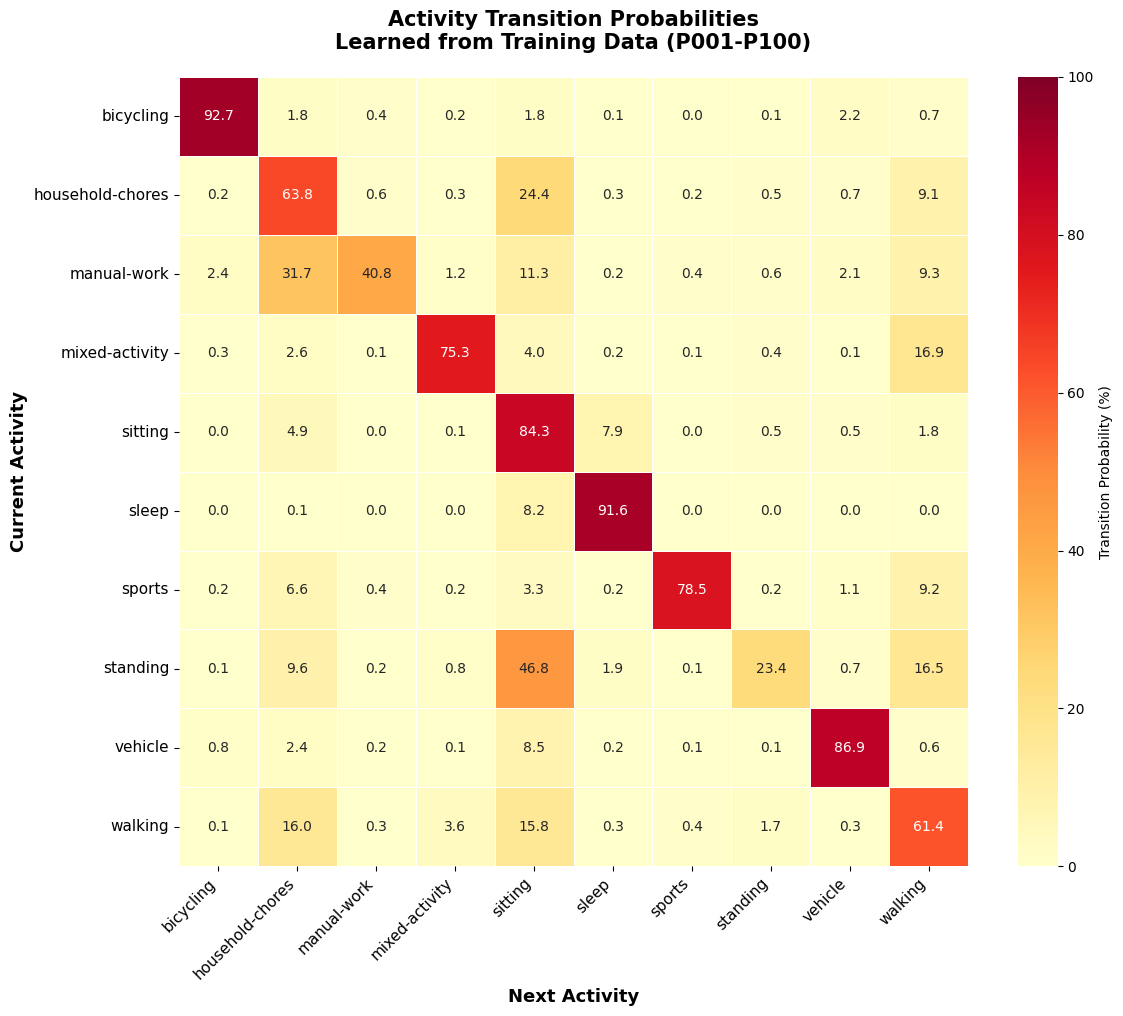


Key Transition Patterns:

High Persistence (Self-Transitions >80%):
  Sleep: 91.6% - People sleep for hours
  Vehicle: 86.9% - Car rides are continuous
  Sitting: 84.3% - Sitting activities persist
  Bicycling: 92.7% - Cycling sessions are long

Low Persistence (<50%):
  Standing: 23.4% - Brief transitional activity
  Manual-work: 40.8% - Often switches to other work

Common Transitions (>15%):
  Household-chores → Sitting: 24.4%
  Manual-work → Household-chores: 31.7%
  Standing → Sitting: 46.8%
  Walking → Household-chores: 16.0%
  Mixed-activity → Walking: 16.9%


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your transition matrix data
activities = ['bicycling', 'household-chores', 'manual-work', 'mixed-activity', 
              'sitting', 'sleep', 'sports', 'standing', 'vehicle', 'walking']

# Transition probabilities (from your learned matrix)
# You can replace this with your actual transitions matrix
# For now, recreating based on your image
transition_data = [
    [92.7, 1.8, 0.4, 0.2, 1.8, 0.1, 0.0, 0.1, 2.2, 0.7],  # bicycling
    [0.2, 63.8, 0.6, 0.3, 24.4, 0.3, 0.2, 0.5, 0.7, 9.1],  # household-chores
    [2.4, 31.7, 40.8, 1.2, 11.3, 0.2, 0.4, 0.6, 2.1, 9.3],  # manual-work
    [0.3, 2.6, 0.1, 75.3, 4.0, 0.2, 0.1, 0.4, 0.1, 16.9],  # mixed-activity
    [0.0, 4.9, 0.0, 0.1, 84.3, 7.9, 0.0, 0.5, 0.5, 1.8],  # sitting
    [0.0, 0.1, 0.0, 0.0, 8.2, 91.6, 0.0, 0.0, 0.0, 0.0],  # sleep
    [0.2, 6.6, 0.4, 0.2, 3.3, 0.2, 78.5, 0.2, 1.1, 9.2],  # sports
    [0.1, 9.6, 0.2, 0.8, 46.8, 1.9, 0.1, 23.4, 0.7, 16.5],  # standing
    [0.8, 2.4, 0.2, 0.1, 8.5, 0.2, 0.1, 0.1, 86.9, 0.6],  # vehicle
    [0.1, 16.0, 0.3, 3.6, 15.8, 0.3, 0.4, 1.7, 0.3, 61.4]   # walking
]

# Or use your actual transition matrix:
# transition_data = transitions * 100  # If you have the transitions variable

# Create heatmap
plt.figure(figsize=(12, 10))

sns.heatmap(
    transition_data,
    annot=True,
    fmt='.1f',
    cmap='YlOrRd',
    xticklabels=activities,
    yticklabels=activities,
    cbar_kws={'label': 'Transition Probability (%)'},
    linewidths=0.5,
    linecolor='white',
    square=True,
    vmin=0,
    vmax=100
)

plt.xlabel('Next Activity', fontsize=13, fontweight='bold')
plt.ylabel('Current Activity', fontsize=13, fontweight='bold')
plt.title('Activity Transition Probabilities\nLearned from Training Data (P001-P100)',
          fontsize=15, fontweight='bold', pad=20)

# Rotate labels
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)

plt.tight_layout()
plt.savefig('transition_matrix_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Print key insights
print("\nKey Transition Patterns:")
print("="*70)
print("\nHigh Persistence (Self-Transitions >80%):")
print(f"  Sleep: 91.6% - People sleep for hours")
print(f"  Vehicle: 86.9% - Car rides are continuous")
print(f"  Sitting: 84.3% - Sitting activities persist")
print(f"  Bicycling: 92.7% - Cycling sessions are long")

print("\nLow Persistence (<50%):")
print(f"  Standing: 23.4% - Brief transitional activity")
print(f"  Manual-work: 40.8% - Often switches to other work")

print("\nCommon Transitions (>15%):")
print(f"  Household-chores → Sitting: 24.4%")
print(f"  Manual-work → Household-chores: 31.7%")
print(f"  Standing → Sitting: 46.8%")
print(f"  Walking → Household-chores: 16.0%")
print(f"  Mixed-activity → Walking: 16.9%")